# Assignment 5, Question 2: Physics Informed Neural Networks

### Importing the necessary libraries

In [1]:
import sys
import torch
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import matplotlib.pyplot as plt


np.random.seed(1234)

In [2]:
# Uncomment this to install the PyDOE package.
# !pip install pyDOE

In [3]:
# Enable use of the GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

We will use a Fully Connected Neural Network to solve this PDE. The network will take in two features as input, $x$, the spatial co-ordinate, and $t$, the time co-ordinate. From these two inputs, the network should output the solution to the PDE at that point in space and time. For instance, the solution to a PDE given by $u_t = -u u_x + \nu u_{xx}$ is going to be the function $u(y,t)$. Our goal would be to pass in a given y-coordinate and time value to this network, and output the corresponding value of $f$. 

The first thing we'll do on the path towards implementing this is to define a *fully-connected* neural network with two nodes as input, one node as output, and several hidden layers in between. A good starting point would be to have 5 hidden layers with 50 neurons each, bias applied at each layer, and tanh() activation in between each linear layer.

In [4]:
# TO-DO: Construct a Fully Connected Neural Network to take in two features, and output one feature
class FCNN(torch.nn.Module):

    def __init__(self):
        super(FCNN, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, 50)
        self.fc2 = torch.nn.Linear(50, 50)
        self.fc3 = torch.nn.Linear(50, 50)
        self.fc4 = torch.nn.Linear(50, 50)
        self.fc5 = torch.nn.Linear(50, 1)

        # Define layers and network components here
#         pass
    def forward(self, x):
        # TO-DO: Define forward pass, including hidden layers
        # Use tanh() activation between each layer, except after the final layer
        # Choice of network structure is up to you, a good starting point is 5 layers with 50 neurons per layer
        x = self.fc1(x)
        x = torch.tanh(x)
        
        x = self.fc2(x)
        x = torch.tanh(x)
        
        x = self.fc3(x)
        x = torch.tanh(x)
        
        x = self.fc4(x)
        x = torch.tanh(x)
        
        x = self.fc5(x)

#         pass
        return x
        #return output

## Dataset Configuration

After you've defined the network architecture above, the next step is to create a dataset. Since our goal is to train a model that can predict the PDE solution at some arbitrary space co-ordinate and time co-ordinate, we need to randomly sample some space and time co-ordinates to act as the training input for the model.

To do so, we'll first:

1. Define a grid spanning all possible x, t combinations. If we have $N$ possible values of $x$ and $M$ possible values of t, we'll have $N_{samples} = N\times M$ combinations of $x$ and $t$.
2. Reshape this grid into a feature matrix, of shape ($N_{samples}$, $N_{features}$). We'll use $N_{samples}$ from (1.), and we have two  $N_{features}$ = 2 ($x$ and $t$).
3. Extract the vectors from the grid that define the intitial condition, and the left and right boundaries of the domain. We'll also reshape these vectors into a feature matrix.
4. Randomly sample these points to create a training set.

We'll use a direct MSE loss to make sure that the predictions of the network at the boundary and initial conditions are the correct values, and a loss based on the PDE residual for points in $(x,t)$ space that do not lie on the boundary or initial conditions. 

Some of the code to do this has been provided below, please fill in the blanks where indicated.

In [5]:
# TO-DO: a) Defining the dataset.

# Nu defines the value for viscosity
nu = 0.01 / np.pi 


# Number of points to sample on u(x,t) 
N_u = 100 # Number of samples for the MSE loss function
N_f = 10000 # Number of samples for the physics-based loss function

# Load in data
data = np.load('./q2_data.npy')
gt_solution = data.T


# 100 elements in the time dimension (Note, shape should be (100,1). You may have to reshape your vector.)
t_vector = np.linspace(0,1,100).reshape(100,1)

# 256 elements in the space dimension (Note, shape should be (256,1). You may have to reshape your vector.)
x_vector = np.linspace(-1,1,256).reshape(256,1)


# Create a grid of x, t values using np.meshgrid(), and store them in arrays called xx, and tt. This gives us every possible combination of the space and time co-ordinates within the bounds of the solution.
# This is similar to what was done in HW4 to create the mesh for drawing the decision boundary. The xx array stores the x co-ordinates for the combinations of x and t, and the tt array stores the t co-ordinates for the combinations of x and t. Both arrays should also be 256 x 100. 
xx, tt = np.meshgrid(x_vector,t_vector) 



<ipython-input-6-a0f664144965>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx ,tt, xx)


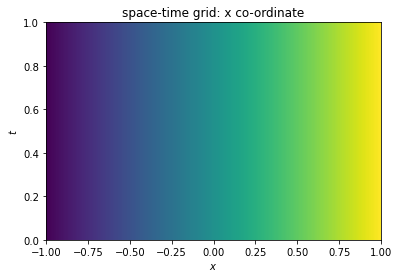

<ipython-input-6-a0f664144965>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, tt, tt)


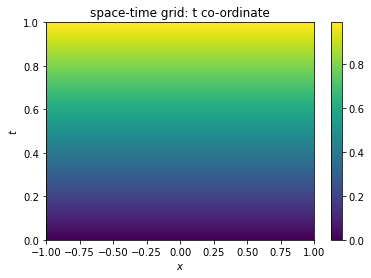

In [6]:
plt.pcolormesh(xx ,tt, xx)
plt.title('space-time grid: x co-ordinate')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.colorbar
plt.show()
plt.pcolormesh(xx, tt, tt)
plt.title('space-time grid: t co-ordinate')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.colorbar()
plt.show()

In [7]:
# TO-DO: Next, reshape the xx and tt arrays to be of shape (25600, 1), and stack them together (np.hstack), creating a combined x and t array of shape (25600, 2).
xt_combined_flat = np.hstack((xx.reshape(25600,1),tt.reshape(25600,1)))

# Reshape the gt_solution data array to be of shape (25600, 1) in an array called u_flat
u_flat = data.reshape(25600,1) # u_flat is the ground truth data, defined for all 25600 combinations of x and t.        

# Domain bounds
# lb should be the minimum x and t values, stored as a numpy array of shape (1,2). The structure should be [x_min, t_min].
lb_numpy = np.array([min(x_vector),min(t_vector)]).reshape(1,2)
# ub should be the maximum x and t values, stored as a numpy array of shape (1,2). The structure should be [x_max, t_max].
ub_numpy = np.array([max(x_vector),max(t_vector)]).reshape(1,2)


# Define the initial conditions: t = 0. 
# initial_conditions_xt is a 256 x 2 vector containing the x and t values at the initial condition.
# initial_condition_u is a 256 x 1 vector storing u at the initial condition
initial_condition_xt = xt_combined_flat[0:256,:]
initial_condition_u = np.hstack((np.zeros(128),np.ones(128))).reshape(256,1)


# Defining the left boundary: (x = -1).
# left_boundary_xt is a 100 x 2 vector containing the x and t values at the left boundary.
# left_boundary_u is a 100 x 1 vector storing u at the left boundary.
left_boundary_xt = xt_combined_flat[xt_combined_flat[:, 0] == -1, :]
left_boundary_u = np.ones(100).reshape(100,1)

# Defining the right boundary: (x = 1)
# right_boundary_xt is a 100 x 2 vector containing the x and t values at the right boundary.
# right_boundary_u is a 100 x 1 vector storing u at the right boundary.
right_boundary_xt = xt_combined_flat[xt_combined_flat[:, 0] == 1, :]
right_boundary_u = np.ones(100).reshape(100,1)

# Stack the initial condition, left boundary condition, and right boundary condition together into one matrix
edge_samples_xt = np.vstack([initial_condition_xt, left_boundary_xt, right_boundary_xt])
# Sample randomly within the x,t space to create points for training
random_samples_xt = lb_numpy + (ub_numpy-lb_numpy)*lhs(2, N_f)
# Stack the [x,t] coordinates random samples with the boundary to create a training set for the PDE Loss
all_samples_xt = np.vstack((random_samples_xt, edge_samples_xt))

# Stack the ground truth data at the boundary, initial conditions 
edge_samples_u = np.vstack([initial_condition_u, left_boundary_u, right_boundary_u])
# Randomly sample a training set for the MSE loss from the data at the initial and boundary conditions.
idx = np.random.choice(edge_samples_xt.shape[0], N_u, replace=False)
train_samples_xt = edge_samples_xt[idx, :]
train_samples_u = edge_samples_u[idx,:] 

Text(0.5, 1.0, 'Initial condition')

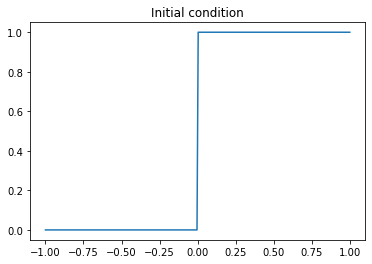

In [8]:
# Plot the initial condition as a function of x
plt.plot(initial_condition_xt[:,0],initial_condition_u[:,0]) 
plt.title('Initial condition')

Next, we'll convert all of these data vectors into torch tensors. To convert a NumPy array to a Torch tensor, the baseline syntax is ```torch.tensor(arr)```, where ```arr``` is the original numpy array. For each array, also convert it to a floating point array and put it on the GPU: ```torch.tensor(arr).float().to(device)```.

You can specify manually if the gradient of a torch Tensor is also required with the argument ```requires_grad = True``` passed to the torch.tensor() function. 

In [9]:

# TO-DO: Convert lower and upper bounds to torch tensors. No gradient is required for these.
lb_torch = torch.tensor(lb_numpy).float().to(device)
ub_torch = torch.tensor(ub_numpy).float().to(device)

# Convert x and t data to torch Tensors. Specify that the gradient is required while converting it to a Tensor. 
# train_samples_xt and all_samples_xt are 2-column matrices with x and t as columns. Here we'll split these up, assigning the x_u and x_f variable to just
# be x, and t_u and t_f to just be t. 
x_boundary_train =  torch.tensor(train_samples_xt[:,0].reshape(100,1), requires_grad = True).float().to(device) # assign x column of train_samples_xt to x_u, convert to torch tensor with gradient 
t_boundary_train =  torch.tensor(train_samples_xt[:,1].reshape(100,1), requires_grad = True).float().to(device) # assign t column of train_samples_xt to t_u, convert to torch tensor with gradient
x_sampled_train = torch.tensor(all_samples_xt[:,0].reshape(10456,1), requires_grad = True).float().to(device)  # assign x column of all_samples_xt to x_f, convert to torch tensor with gradient
t_sampled_train =  torch.tensor(all_samples_xt[:,1].reshape(10456,1), requires_grad = True).float().to(device)# assign t column of all_samples_xt to t_f, convert to torch tensor with gradient

# Convert train_samples_u to torch tensor, no gradient is required. 
u_boundary_train = torch.tensor(train_samples_u).float().to(device)



f_for_loss = torch.zeros((x_sampled_train.shape[0], 1)).float().to(device)
# x_boundary_train    self.x_u
# t_boundary_train    self.t_u
# x_sampled_train     self.x_f
# t_sampled_train     self.t_f

# u_boundary_train    self.u

# torch.zeros((self.x_sampled_train.shape[0], 1))      self.null           torch.zeros((self.x_f.shape[0], 1))

print('self.x_u',x_boundary_train.shape)
print('self.t_u',t_boundary_train.shape)
print('self.x_f',x_sampled_train.shape)
print('self.t_f',t_sampled_train.shape)
print('self.u',u_boundary_train.shape)
print('self.null',f_for_loss.shape)

self.x_u torch.Size([100, 1])
self.t_u torch.Size([100, 1])
self.x_f torch.Size([10456, 1])
self.t_f torch.Size([10456, 1])
self.u torch.Size([100, 1])
self.null torch.Size([10456, 1])


## Training

In [10]:
# b): Initialize the Deep Neural Network, and put it on the GPU.
fcnn = FCNN().to(device)

# Use the following optimizer to optimize your function.
optimizer = torch.optim.LBFGS(
    fcnn.parameters(), 
    lr=1.0, 
    max_iter=50000, 
    max_eval=50000, 
    history_size=50,
    tolerance_grad=1e-5, 
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe"      
)

iter = 0
# c) Calling the network and calculating loss
## The function net_u takes in a neural network (fcnn), x, and t, and returns the prediction of the PDE solution at that combination  of x and t.
def net_u(fcnn, x, t):  
    # Call the fcnn network with the x and t co-ordinates, return the prediction.
    u = fcnn(torch.hstack((x, t)))
    # return network output
    return u
#     pass
## The function net_f, takes in the net_u function, x, and t, and computes the residual of the PDE using gradients calculated from torch.autograd().
def net_f(fcnn, x, t):
    # Calculate the residual of the PDE, using the gradients computed via autograd, and the output of net_u as your predicted u.

    # Step 1: Using the function net_u, calculate the predicted u variable.
    # Step 2: Compute the gradients used in the Burgers' equation PDE using torch.autograd().
    # Step 3: Calculate the residual.
    # return PDE residual
    u = net_u(fcnn, x, t)
    u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
    
    
    u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
    
    u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]
    
    f = u_t + (u * u_x) - (nu * u_xx)
    
    return f


iteration = 0



## The loss function will calculate the loss as a combination of the MSE loss on the boundaries, and the PDE residual loss elsewhere.
def loss_func():#x_boundary_train, t_boundary_train, x_sampled_train , t_sampled_train, u_boundary_train, f_for_loss
    optimizer.zero_grad()
    # Predict the solution along the intitial and boundary conditions
    u_pred = net_u(fcnn, x_boundary_train, t_boundary_train)
    # Predict the solution at the sampled co-location points
    f_pred = net_f(fcnn, x_sampled_train, t_sampled_train)
    # Compute MSE loss on (x,t) points that lie on initial and boundary conditions, PDE loss from co-located sampled points, add them together
#     print('1')
    
    loss_function = torch.nn.MSELoss(reduction ='mean')
#     print('1')
    mse_loss = loss_function(u_boundary_train , u_pred)
    
#     print('2')
    pde_loss = loss_function(f_for_loss , f_pred)
#     print('3')
    total_loss = mse_loss + pde_loss
#     print('4')

    global iteration # iteration keeps track of the current iteration count
    
    # Uncomment line below to backpropagate loss
    total_loss.backward()
#     print('5')


    # Print out iteration progress by uncommenting the following line:
    iteration = iteration + 1 
#     print('6')
    if iteration % 500 == 0:
        print(
            'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (iteration, total_loss.item(), mse_loss.item(), pde_loss.item())
        )
#     pass 
#     print(total_loss)
#     print
    return total_loss

# This initializes the gradients for training
fcnn.train()
    
# This carries out the entire optimization process with L-BFGS, by calling the loss_func function and updating the weights of the fcnn internally.
optimizer.step(loss_func) 
# loss_func()

Iter 500, Loss: 1.58596e-03, Loss_u: 6.23513e-04, Loss_f: 9.62445e-04
Iter 1000, Loss: 2.40200e-04, Loss_u: 1.12865e-04, Loss_f: 1.27335e-04
Iter 1500, Loss: 1.14520e-04, Loss_u: 5.88283e-05, Loss_f: 5.56918e-05
Iter 2000, Loss: 7.30029e-05, Loss_u: 4.74594e-05, Loss_f: 2.55435e-05
Iter 2500, Loss: 6.13107e-05, Loss_u: 4.47119e-05, Loss_f: 1.65988e-05
Iter 3000, Loss: 5.63174e-05, Loss_u: 4.40603e-05, Loss_f: 1.22572e-05
Iter 3500, Loss: 5.32499e-05, Loss_u: 4.38098e-05, Loss_f: 9.44007e-06
Iter 4000, Loss: 5.10687e-05, Loss_u: 4.35542e-05, Loss_f: 7.51446e-06


tensor(0.6914, device='cuda:0', grad_fn=<AddBackward0>)

In [11]:
# d) Given a 2-D array of space and time variables, predict the corresponding PDE solution, and the residual from the PDE. 
def predict(xt):
    # As before, separate xt into vectors and convert these vectors of time and space into torch tensors that require gradients
    x_torch = torch.tensor(xt[:,0].reshape(xt.shape[0],1), requires_grad = True).float().to(device)  # assign x column of xt to x_torch, convert to torch tensor with gradient 
    t_torch = torch.tensor(xt[:,1].reshape(xt.shape[0],1), requires_grad = True).float().to(device) # assign t column of xt to x_torch, convert to torch tensor with gradient 
    fcnn.eval()
    # TO-DO: get predicted u and PDE residual from networks.
    u_pred = net_u(fcnn, x_torch, t_torch)
    f_pred = net_f(fcnn, x_torch, t_torch)
    u = u_pred.detach().cpu().numpy()
    f = f_pred.detach().cpu().numpy()
    return u, f

Compute the following error metrics

Normalized $L_2$ Error, $E_{L_2}$:

$$ E_{L_2}= \frac{\sum_{x,t} \left ( u(x,t)_{gt} - u(x,t)_{pred} \right )^2 }{\sum_{x,t} u(x,t)_{gt}^2}$$

$L_1$ Error, $E_{L_1}$

$$ E_{L_1} = \sum_{x,t} \left | u(x,t)_{gt} - u(x,t)_{pred} \right |$$


In [12]:
# Predict the PDE solution for every combination of x and t

u_pred, f_pred = predict(xt_combined_flat)
# Compute the normalized L2 error of the solution
error_el2 = (sum((gt_solution.reshape(u_pred.shape) - u_pred)**2))/sum(gt_solution.reshape(u_pred.shape)**2)
print('Normalized L2 Error: %e' % (error_el2))                     
# Compute the L1 error of the solution.
error_el1 = sum(abs(gt_solution.reshape(u_pred.shape) - u_pred))
print('Normalized L1 Error: %e' % (error_el1))    

Normalized L2 Error: 1.562759e-03
Normalized L1 Error: 1.955382e+02


## Plotting Results



Based on your results from the previous question, we're now going to plot the evolution of the Burgers' equation over time, as well as some comparisons between the ground truth solution and the predicted solution.

Figure 1: Plotting a comparison of the ground truth solution to the predicted solution at various times.

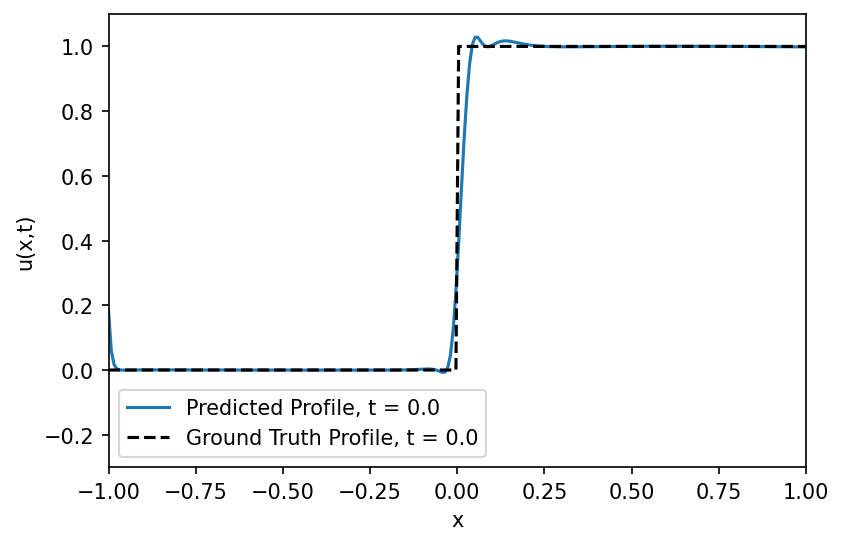

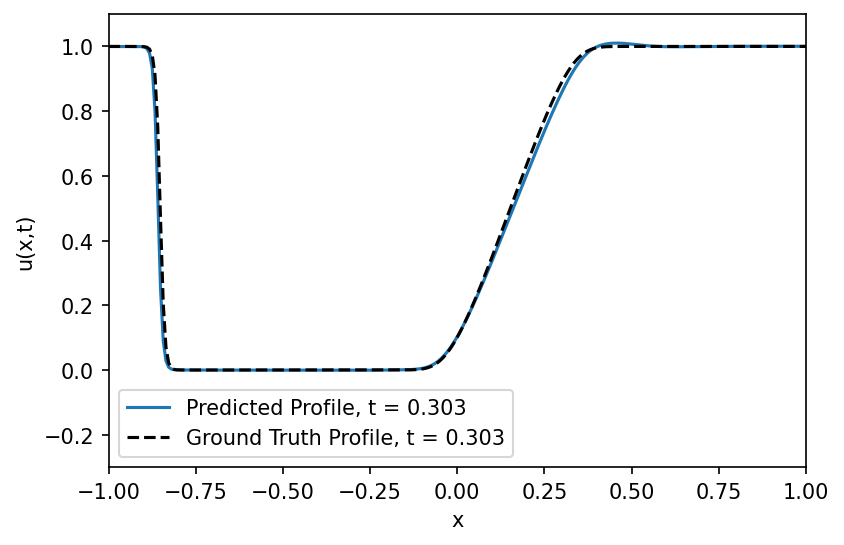

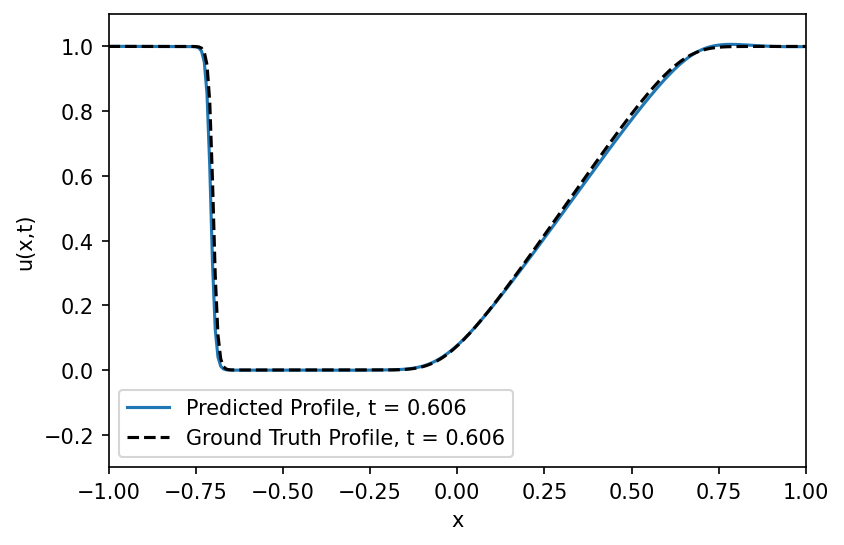

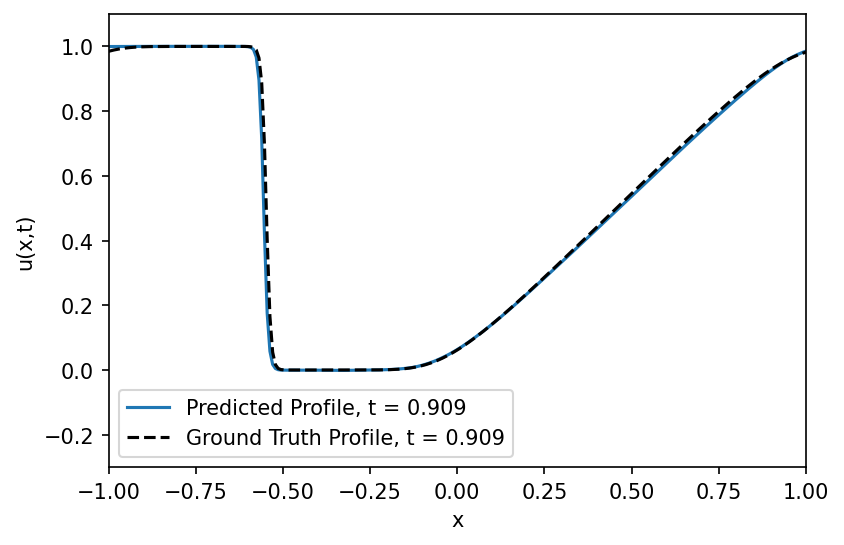

In [13]:
# Interpolate array for plotting.
u_pred_grid = griddata(xt_combined_flat, u_pred.flatten(), (xx, tt), method='cubic')
Error = np.abs(gt_solution - u_pred_grid)

for i in range(0, 100, 30):
    plt.figure(dpi = 150)
    plt.plot(x_vector[:,0],u_pred_grid[i,:], label = 'Predicted Profile, t = {:.03}'.format(t_vector[i][0]))
    plt.plot(x_vector[:,0],gt_solution[i,:], 'k--', label = 'Ground Truth Profile, t = {:.03}'.format(t_vector[i][0]))
    plt.legend()
    plt.ylim([-0.3,1.1])
    plt.xlim([-1,1])
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.show()


Figure 2: Plotting the time evolution of the 1-D Burgers equation as a 2-D image

<ipython-input-16-b77150eb92c3>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tt.T,xx.T,u_pred_grid.T, cmap= 'jet', vmin  =0, vmax = 1)


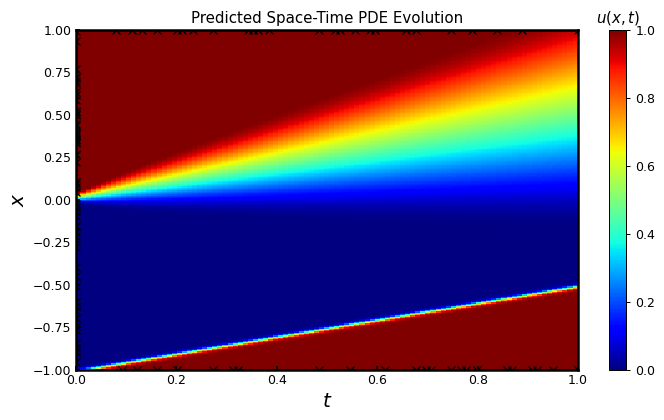

<ipython-input-16-b77150eb92c3>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tt.T,xx.T,gt_solution.T, cmap= 'jet', vmin  =0, vmax = 1)


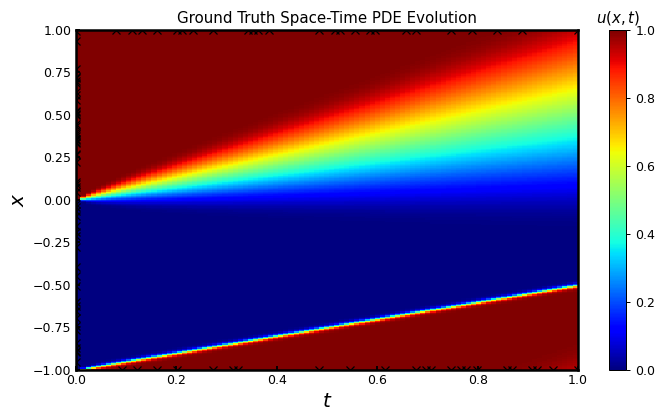

<ipython-input-16-b77150eb92c3>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tt.T,xx.T,Error.T, cmap= 'jet', vmin = 0, vmax = 1)


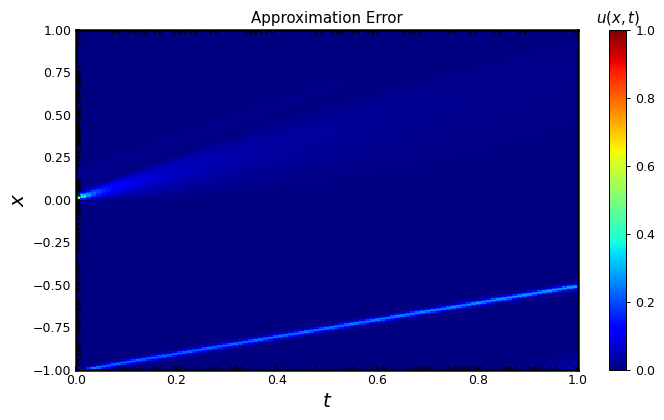

In [16]:
plt.figure(dpi = 90, figsize  = [9,5])
plt.pcolormesh(tt.T,xx.T,u_pred_grid.T, cmap= 'jet', vmin  =0, vmax = 1)
plt.ylabel(r'$x$', fontsize = 16)
plt.xlabel(r'$t$', fontsize = 16)

plt.plot(train_samples_xt[:,1], train_samples_xt[:,0], 'kx')


plt.title('Predicted Space-Time PDE Evolution')
ax = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2.0)
plt.tick_params(direction = 'in', width = 1.5)
clb= plt.colorbar()
clb.ax.set_title(r'$u (x,t)$')

plt.show()
plt.figure(dpi = 90, figsize  = [9,5])
plt.pcolormesh(tt.T,xx.T,gt_solution.T, cmap= 'jet', vmin  =0, vmax = 1)
plt.ylabel(r'$x$', fontsize = 16)
plt.xlabel(r'$t$', fontsize = 16)

plt.plot(train_samples_xt[:,1], train_samples_xt[:,0], 'kx')

clb = plt.colorbar()
clb.ax.set_title(r'$u (x,t)$')
plt.title('Ground Truth Space-Time PDE Evolution')
ax = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2.0)
plt.tick_params(direction = 'in', width = 1.5)
plt.show()


plt.figure(dpi = 90, figsize  = [9,5])
plt.pcolormesh(tt.T,xx.T,Error.T, cmap= 'jet', vmin = 0, vmax = 1)
plt.ylabel(r'$x$', fontsize = 16)
plt.xlabel(r'$t$', fontsize = 16)

plt.plot(train_samples_xt[:,1], train_samples_xt[:,0], 'kx')

clb = plt.colorbar()
clb.ax.set_title(r'$u (x,t)$')
plt.title('Approximation Error')
ax = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2.0)
plt.tick_params(direction = 'in', width = 1.5)
plt.show()

Figure 3: Plotting the solution at t = 1 s for $\nu = 1.0, 0.1, \frac{0.01}{\pi}$ on the same figure. 

Iter 500, Loss: 1.91544e-02, Loss_u: 1.87848e-02, Loss_f: 3.69518e-04
Iter 1000, Loss: 1.74232e-02, Loss_u: 1.70433e-02, Loss_f: 3.79926e-04
Iter 1500, Loss: 1.36745e-02, Loss_u: 1.24217e-02, Loss_f: 1.25275e-03
Iter 2000, Loss: 1.08243e-02, Loss_u: 1.01780e-02, Loss_f: 6.46288e-04
Iter 2500, Loss: 1.01757e-02, Loss_u: 9.50433e-03, Loss_f: 6.71414e-04
Iter 3000, Loss: 9.58015e-03, Loss_u: 8.92834e-03, Loss_f: 6.51809e-04
Iter 3500, Loss: 9.27384e-03, Loss_u: 8.70190e-03, Loss_f: 5.71948e-04
Iter 4000, Loss: 8.92731e-03, Loss_u: 8.39749e-03, Loss_f: 5.29816e-04
Iter 4500, Loss: 8.67558e-03, Loss_u: 8.18936e-03, Loss_f: 4.86221e-04
Iter 5000, Loss: 8.40260e-03, Loss_u: 7.88321e-03, Loss_f: 5.19387e-04
Iter 5500, Loss: 8.08065e-03, Loss_u: 7.46544e-03, Loss_f: 6.15218e-04
Iter 500, Loss: 9.01065e-03, Loss_u: 7.56317e-03, Loss_f: 1.44748e-03
Iter 1000, Loss: 3.37067e-03, Loss_u: 2.80475e-03, Loss_f: 5.65922e-04
Iter 1500, Loss: 2.65819e-03, Loss_u: 2.27813e-03, Loss_f: 3.80056e-04
Iter 200

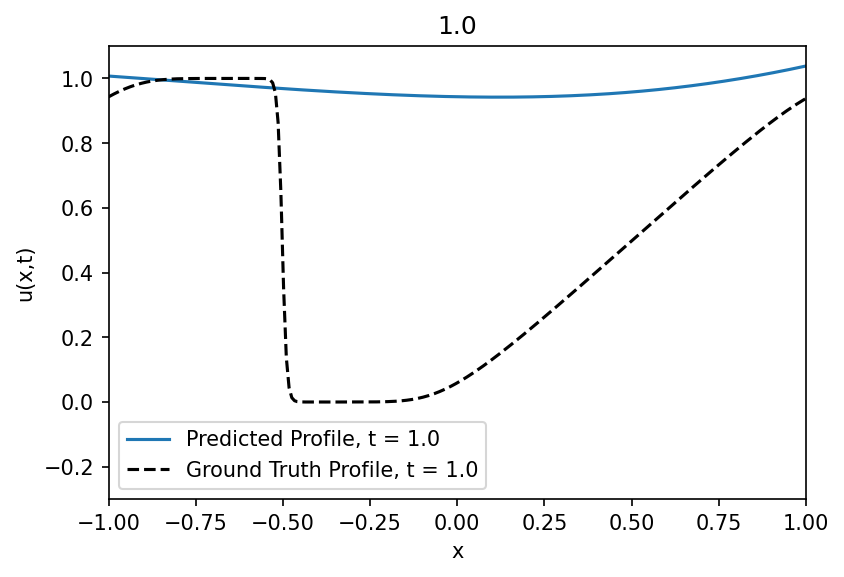

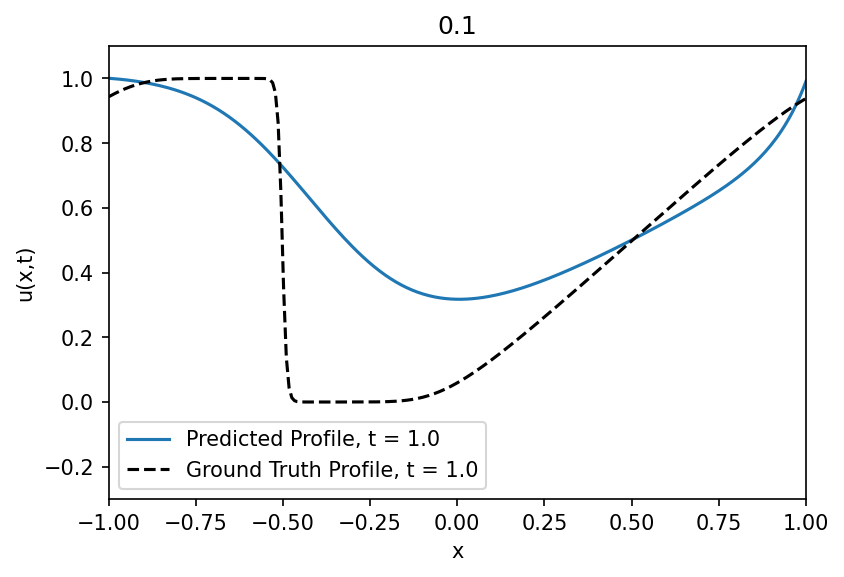

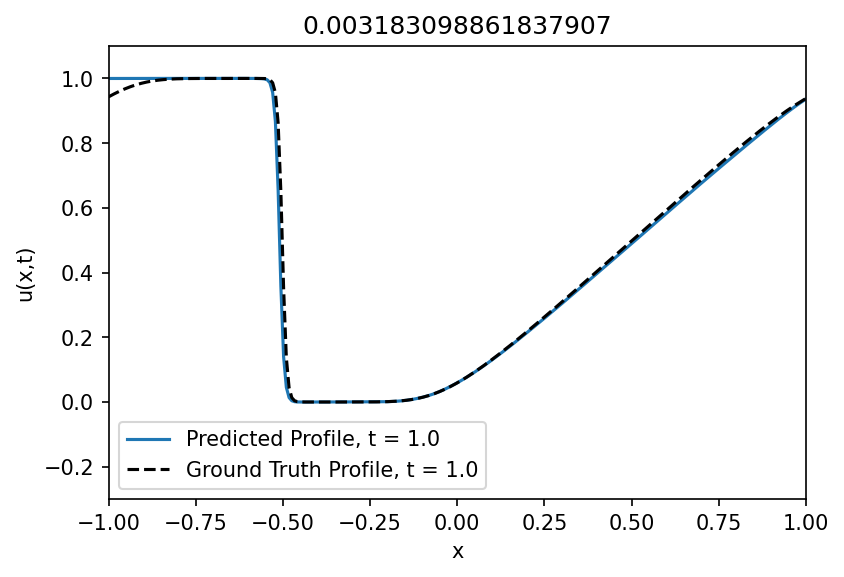

In [15]:
# e)
nu_lst = [1.0 , 0.1 , 0.01 / np.pi]

for nu in nu_lst:
    fcnn = FCNN().to(device)
    
    optimizer = torch.optim.LBFGS(
    fcnn.parameters(), 
    lr=1.0, 
    max_iter=50000, 
    max_eval=50000, 
    history_size=50,
    tolerance_grad=1e-5, 
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe"      
)
    iter = 0
    iteration = 0
    fcnn.train()
    optimizer.step(loss_func) 
    u_pred, f_pred = predict(xt_combined_flat)
    u_pred_grid = griddata(xt_combined_flat, u_pred.flatten(), (xx, tt), method='cubic')
    Error = np.abs(gt_solution - u_pred_grid)

    plt.figure(dpi = 150)
    plt.plot(x_vector[:,0],u_pred_grid[99,:], label = 'Predicted Profile, t = {:.03}'.format(t_vector[99][0]))
    plt.plot(x_vector[:,0],gt_solution[99,:], 'k--', label = 'Ground Truth Profile, t = {:.03}'.format(t_vector[99][0]))
    plt.legend()
    plt.ylim([-0.3,1.1])
    plt.xlim([-1,1])
    plt.title(nu)
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
plt.show()




### Viscosity: The smaller the viscosity the better the model performs in predicting the outcome and better solution is found.

## f)
### Torch.autograd provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions. It requires minimal changes to the existing code. It is useful for implemeting PINNs because all we have to do is specify the tesnors for which gradients should be computed with the requires_grad=True keyword.